In [221]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tqdm
from math import sqrt
import random
from common import get_data, get_freq_data, signal_cyclic_shift
# import seaborn as sns; 
# sns.set()

In [214]:
X, y = get_data('./data/na62_11_pulses.txt')

In [267]:
def get_simillar_signals(idx):
    signal = X[idx]
    ref_time = y[idx]
    mean_signal = np.mean(X, axis=0)

    simillar_signals = []
    for i in range(len(X)):
        cur_ref_time = y[i]
        if np.abs(cur_ref_time - ref_time) < 5:
            simillar_signals.append(X[i])
    simillar_signals = np.array(simillar_signals)
    return simillar_signals

In [388]:
simillar_signals_num = []
for idx in range(len(X)):
    simillar_signals_num.append(len(get_simillar_signals(idx)))

In [393]:
from numpy.fft import rfft, irfft, rfftfreq
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

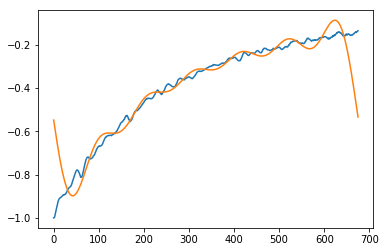

In [451]:
SHIFT = 0
idx = np.random.choice(range(len(X)))
signal = X[idx]
plt.plot(signal[np.argmin(signal)-SHIFT:])
plt.plot(filter_signal(signal[np.argmin(signal)-SHIFT:], threshold=3e2))

2


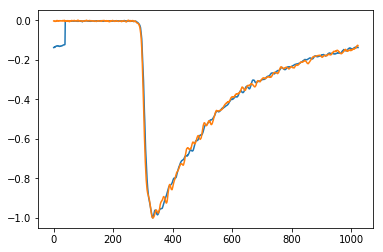

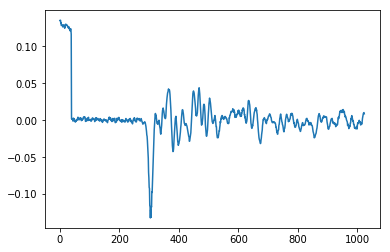

24


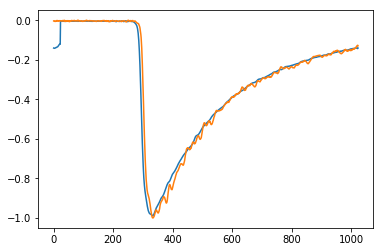

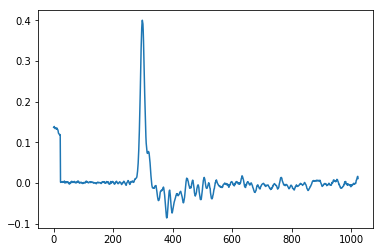

24


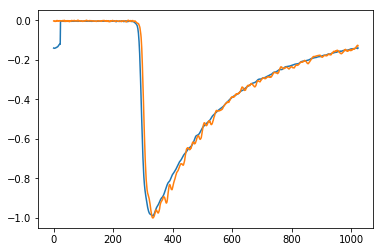

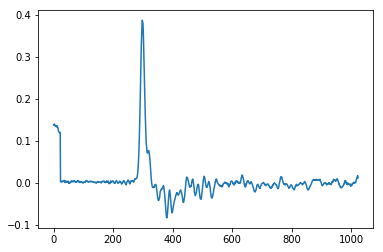

42


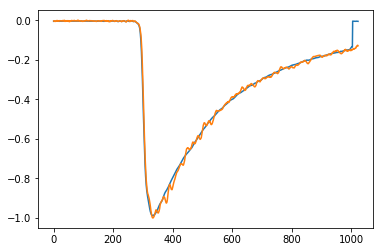

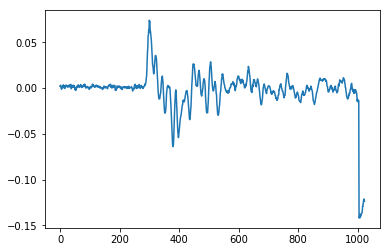

47


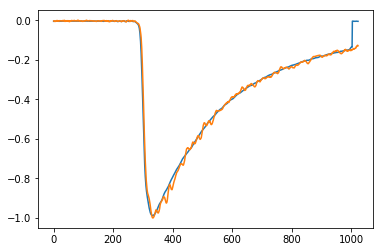

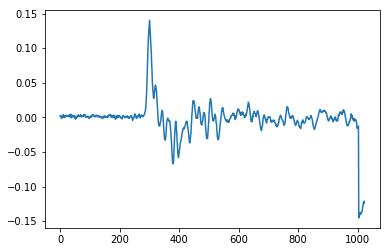

48


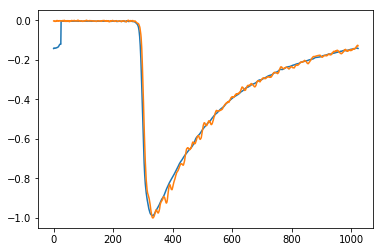

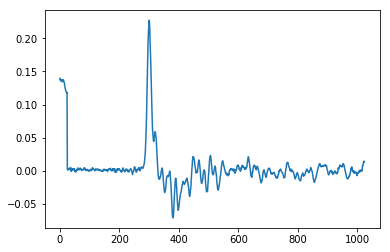

53


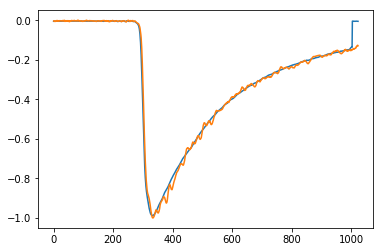

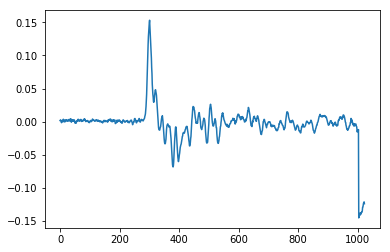

55


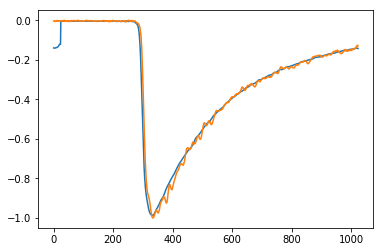

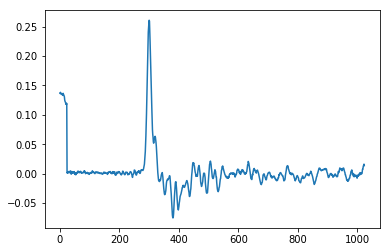

60


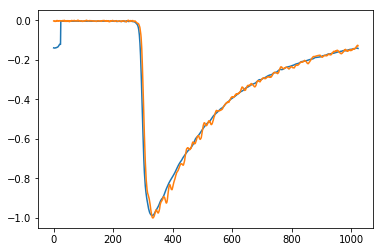

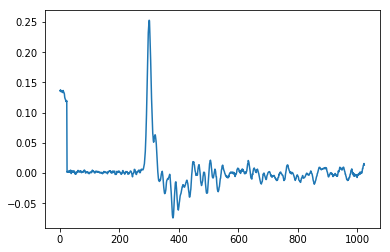

61


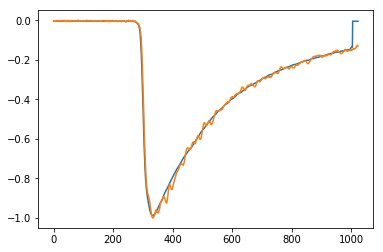

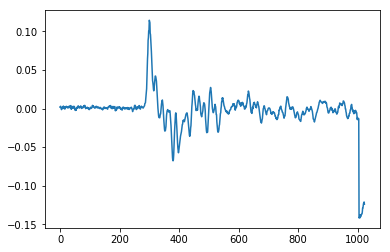

In [391]:
K = 10
sorted_idxs = np.argsort(simillar_signals_num)[:K]
for idx in sorted_idxs[:K]:
    simillar_signals = get_simillar_signals(idx)
    print(len(simillar_signals))
    mean_signal = np.mean(simillar_signals, axis=0)
    mean_signal = signal_cyclic_shift(mean_signal, np.argmin(signal) - np.argmin(mean_signal))
    plt.plot(mean_signal)
    plt.plot(signal)
    plt.show()
    plt.plot(signal - mean_signal)
    plt.show()
    print("===========================")

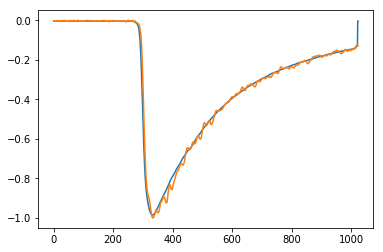

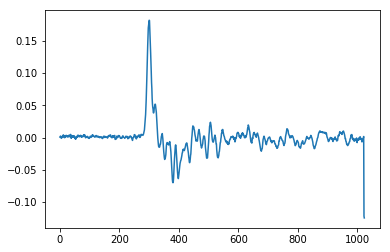

In [372]:
idx = np.random.choice(range(len(X)))
simillar_signals = get_simillar_signals(idx)
mean_signal = np.mean(simillar_signals, axis=0)
mean_signal = signal_cyclic_shift(mean_signal, np.argmin(signal) - np.argmin(mean_signal))
plt.plot(mean_signal)
plt.plot(signal)
plt.show()
plt.plot(signal - mean_signal)
plt.show()

Simillar signals number: 289


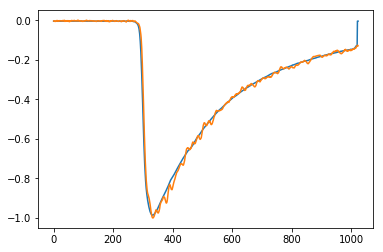

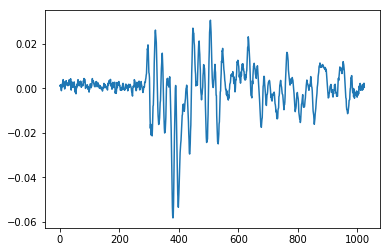

In [265]:
idx = np.random.choice(range(len(X)))
signal = X[idx]
ref_time = y[idx]
mean_signal = np.mean(X, axis=0)

simillar_signals = []
for i in range(len(X)):
    cur_ref_time = y[i]
    if np.abs(cur_ref_time - ref_time) < 5:
        simillar_signals.append(X[i])
simillar_signals = np.array(simillar_signals)

print("Simillar signals number:", len(simillar_signals))
mean_signal = np.mean(simillar_signals, axis=0)

plt.plot(signal_cyclic_shift(mean_signal, np.argmin(signal) - np.argmin(mean_signal)))
plt.plot(signal)
plt.show()
plt.plot(signal - mean_signal)
plt.show()

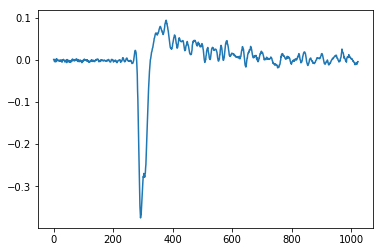

In [215]:
idx = np.random.choice(range(len(X)))
plt.plot(X[idx] - mean_signal)

In [105]:
X_noise = X - mean_signal

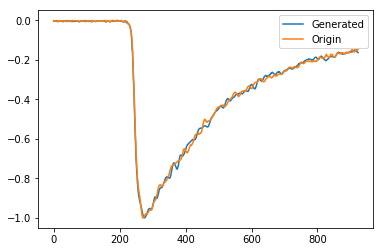

In [169]:
noise = X_noise[np.random.choice(len(X_noise))]
plt.plot(mean_signal + noise)
plt.plot(X[idx])
plt.legend(['Generated', 'Origin'])

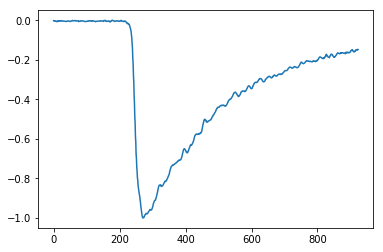

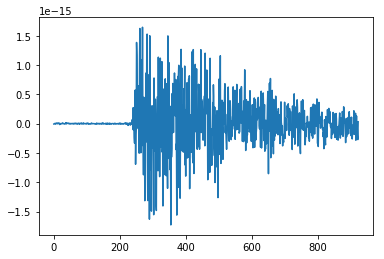

In [102]:
plt.plot(np.mean(X_dif, axis=0))

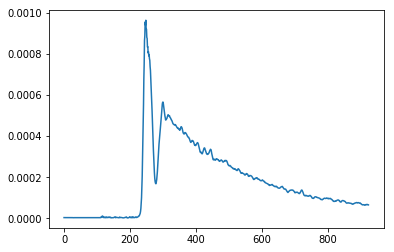

In [104]:
plt.plot(np.var(X_dif, axis=0))

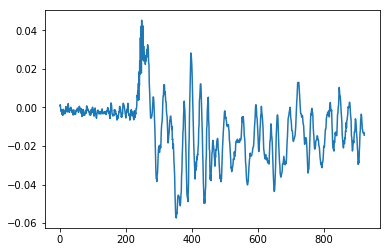

In [99]:
plt.plot(X_dif[1])

In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures

TIME_SCALE_COEF = 0.2

def get_model_scores(X, y, model=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    r2_score = scores['test_r2'].mean()
    mse =  TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean()
    rmse = TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    mae = TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean()
    
    return {'r2': r2_score, 'mse': mse, 'rmse': rmse, 'mae': mae}

def print_model_scores(X, y, model=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    
    print("95% confidence interval:")
    print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
    print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
    print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
    print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

In [4]:
print_model_scores(X[:, :360], y)

95% confidence interval:
r2_score: 0.99547 (+/- 0.00164)
MSE[ns^2]: 0.03088 (+/- 0.05936)
RMSE[ns]: 0.17499 (+/- 0.03208)
MAE[ns]: 0.13427 (+/- 0.01180)


In [5]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster='gbtree', eta=0.040967242033212566, 
                               gamma=0.11403358374490781, max_depth=42, reg_lambda=0.0010412564895330462,
                               alpha=9.720814421482372, verbosity=0)

In [6]:
print_model_scores(X[:, :360], y, model=xgb_reg)

95% confidence interval:
r2_score: 0.99822 (+/- 0.00129)
MSE[ns^2]: 0.01216 (+/- 0.04550)
RMSE[ns]: 0.10866 (+/- 0.03731)
MAE[ns]: 0.07641 (+/- 0.00870)


In [7]:
print_model_scores(X, y, model=xgb_reg)

95% confidence interval:
r2_score: 0.99818 (+/- 0.00128)
MSE[ns^2]: 0.01240 (+/- 0.04509)
RMSE[ns]: 0.10984 (+/- 0.03682)
MAE[ns]: 0.07807 (+/- 0.00887)


In [465]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        return -1
#         raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        return -1
#         raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        return -1
#         raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]


In [ ]:
def denoise_signal

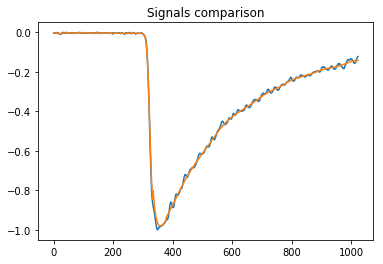

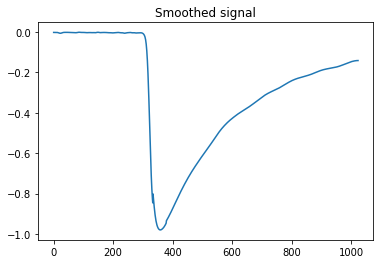

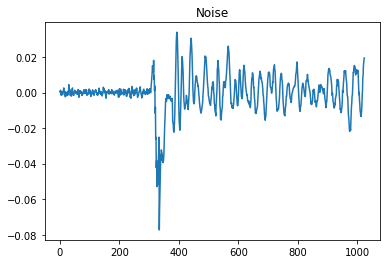

In [881]:
WINDOW_LEN = 100
SHIFT = 30
WINDOW = 'hanning'

idx = np.random.choice(range(len(X)))
signal = X[idx]

front_signal = signal[:np.argmin(signal)]
smooth_front_signal = smooth(front_signal, window_len=WINDOW_LEN//5, window=WINDOW)

back_signal = signal[np.argmin(signal):]
smoth_back_signal = smooth(back_signal, window_len=WINDOW_LEN, window=WINDOW)


middle_signal = signal[np.argmin(signal) - SHIFT:np.argmin(signal) + 2*SHIFT]
smooth_middle_signal = smooth(middle_signal, window_len=WINDOW_LEN//2, window=WINDOW)


smooth_signal = np.concatenate([smooth_front_signal[:-SHIFT//2], \
                                smooth_middle_signal[SHIFT//2:-SHIFT], \
                                smoth_back_signal[SHIFT:]])
noise = signal - smooth_signal
plt.title("Signals comparison")
plt.plot(signal)
plt.plot(smooth_signal)
plt.show()
plt.title("Smoothed signal")
plt.plot(smooth_signal)
plt.show()
plt.title("Noise")
plt.plot(noise)
plt.show()

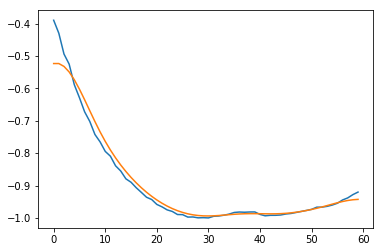

In [816]:
plt.plot(middle_signal)
plt.plot(smooth_middle_signal)
plt.show()

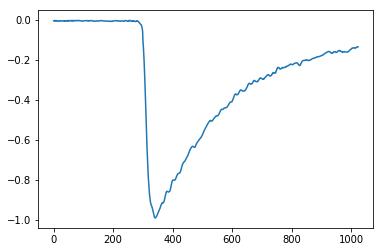

In [807]:
alpha = 0.7
plt.plot(smooth_signal + alpha*noise)
plt.show()

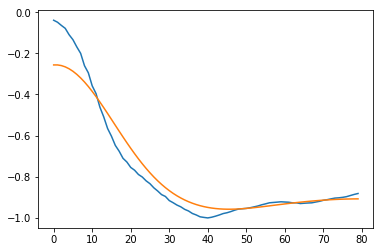

In [784]:
plt.plot(middle_signal)
plt.plot(smooth_middle_signal)

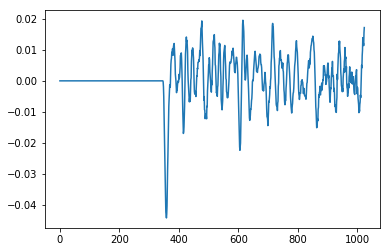

In [567]:
noise = signal - smooth_signal
plt.plot(noise)

In [8]:
TITLE_FONTSIZE = 17
LABEL_FONTSIZE = 16

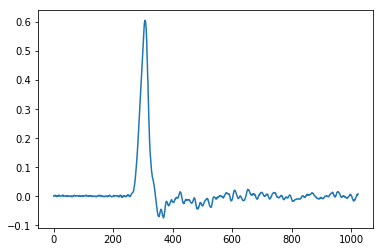

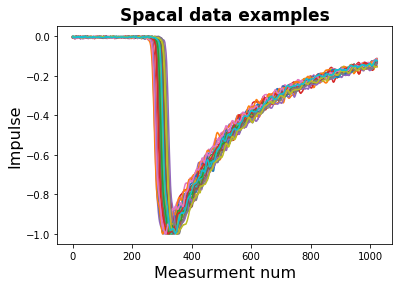

In [9]:
plt.title("Spacal data examples", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
for i in range(30):
    
    plt.plot(X[i])
plt.show()

NameError: name 'X_filtered' is not defined

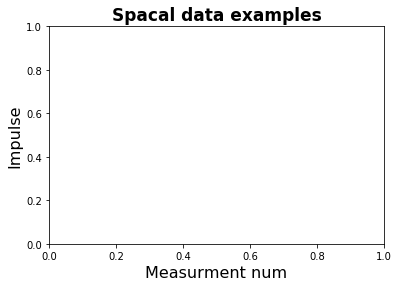

In [10]:
plt.title("Spacal data examples", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
for i in range(30):
    plt.plot(X_filtered[i])
plt.show()

### Model scores after denoising

In [ ]:
window_types = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
window_lens = range(10, 60, 10)
N = -1
scores = {window: {window_len: {'full': None, 'front': None} for window_len in window_lens} for window in window_types}

In [61]:
for window in window_types:
    for window_len in tqdm.tqdm(window_lens):
        X_filtered = np.array([smooth(signal, window_len=window_len, window=window) for signal in X])
        front_rmse = get_model_scores(X_filtered[:N, :360], y[:N], model=xgb_reg)['rmse']
        scores[window][window_len]['front'] = front_rmse
        full_rmse = get_model_scores(X_filtered[:N, :], y[:N], model=xgb_reg)['rmse']
        scores[window][window_len]['full'] = full_rmse


100%|██████████| 5/5 [15:25<00:00, 185.08s/it]

100%|██████████| 5/5 [13:26<00:00, 161.24s/it]

100%|██████████| 5/5 [13:06<00:00, 157.36s/it]

100%|██████████| 5/5 [13:08<00:00, 157.66s/it]

100%|██████████| 5/5 [13:12<00:00, 158.41s/it]


In [62]:
scores

{'flat': {10: {'full': 0.11674916893516663, 'front': 0.11565896821359747},
  20: {'full': 0.11974281097834666, 'front': 0.11969077585005786},
  30: {'full': 0.11999173265439034, 'front': 0.11869405669471447},
  40: {'full': 0.11822858622067652, 'front': 0.11697469840043483},
  50: {'full': 0.12151207764864874, 'front': 0.11975295323623361}},
 'hanning': {10: {'full': 0.11316520255243774, 'front': 0.111981092500339},
  20: {'full': 0.12059208489347716, 'front': 0.12011576522163232},
  30: {'full': 0.11957627763014825, 'front': 0.11903288985606715},
  40: {'full': 0.11697786517520069, 'front': 0.11848616943264419},
  50: {'full': 0.12187734601971267, 'front': 0.12238282169478053}},
 'hamming': {10: {'full': 0.11251062771239909, 'front': 0.11040490888071362},
  20: {'full': 0.1189583695534599, 'front': 0.11920824090942168},
  30: {'full': 0.11724190860921557, 'front': 0.11648666230053482},
  40: {'full': 0.12106269994240314, 'front': 0.12152531604785717},
  50: {'full': 0.1241433395218316

In [66]:
score_origin = 0.10866

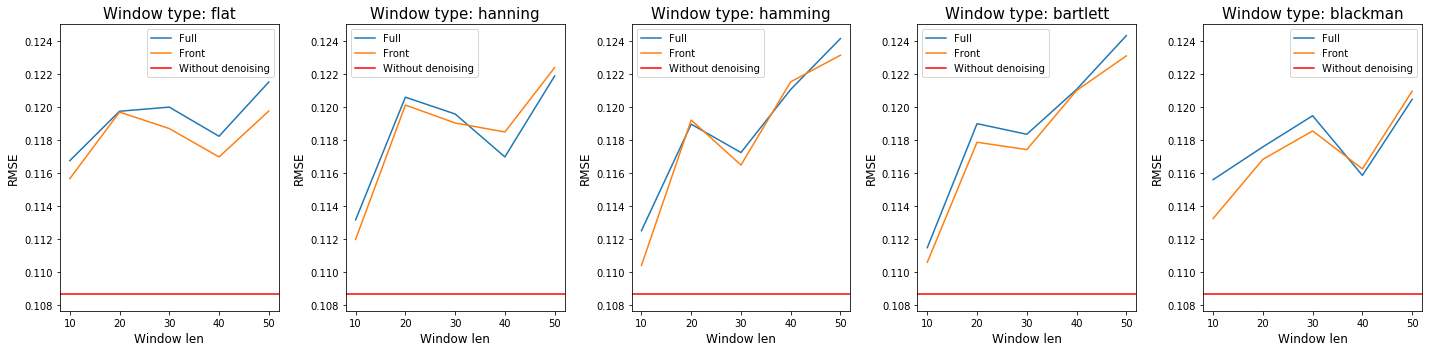

In [76]:
f, ax = plt.subplots(1, len(window_types), figsize=(20,5))
for i, window in enumerate(window_types):
    ax[i].set_title("Window type: {}".format(window), fontsize=15)
    ax[i].set_xlabel("Window len", fontsize=12)
    ax[i].set_ylabel("RMSE", fontsize=12)
    ax[i].set_ylim((score_origin - 0.001, 0.125))
    
    full_scores = [scores[window][window_score]['full'] for window_score in scores[window]]
    ax[i].plot(window_lens, full_scores)
    front_scores = [scores[window][window_score]['front'] for window_score in scores[window]]
    ax[i].plot(window_lens, front_scores)
    ax[i].axhline(y=score_origin, color='r')
    
    ax[i].legend(["Full", "Front", "Without denoising"])
f.tight_layout()
plt.show()

In [ ]:
f, ax = plt.subplots(2, len(window_types), figsize=(15, 5))
for i, window in enumerate(window_types):
    ax[0][i].plot()

### Tuning xgboost

In [11]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp

In [13]:
window_len = 30
window = 'hamming'
X_filtered = np.array([smooth(signal, window_len=window_len, window=window) for signal in X])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, train_size=0.7)

In [33]:
def f(space):
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster=space['booster'], eta=space['eta'], 
                               gamma=space['gamma'], max_depth=space['max_depth'], reg_lambda=space['lambda'],
                               alpha=space['alpha'], verbosity=0)
    scores = cross_validate(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'eta': hp.loguniform('eta', low=np.log(0.001), high=np.log(1)),
    'gamma': hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'max_depth': ho_scope.int(hp.quniform('max_depth', low=5, high=20, q=2)),
    'lambda': hp.loguniform('lambda', low=np.log(1), high=np.log(10)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.001), high=np.log(10)),
}

iter_num = 20
best = fmin(
    fn=f,  # "Loss" function to minimize
    space=space,  # Hyperparameter space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
    max_evals=iter_num  # Perform 100 trials
)

print(best)

100%|██████████| 20/20 [16:52<00:00, 50.64s/it, best loss: 0.5353786306961574]
{'alpha': 1.514484794831762, 'booster': 2, 'eta': 0.12804430694842472, 'gamma': 0.004191396741201962, 'lambda': 9.291425215391417, 'max_depth': 18.0}


In [34]:
xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster='dart', eta=0.128044, 
                               gamma=0.004191396741, max_depth=18, reg_lambda=9.291425215391417,
                               alpha=1.514484794831762, verbosity=0)